# Predict Future Sales
from [kaggle competition](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/)

## 2. EDA and Feature Engineering


## 2-1. Data optimization

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

train = pd.read_csv('data/sales_train_opt_ver1.csv')

In [2]:
# optimize dataset
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609124 entries, 0 to 1609123
Data columns (total 16 columns):
shop_id                          1609124 non-null int64
item_id                          1609124 non-null int64
date_block_num                   1609124 non-null int64
item_cnt_month                   1609124 non-null float64
item_price_month                 1609124 non-null float64
date_month                       1609124 non-null int64
date_year                        1609124 non-null int64
item_cateogory_id                1609124 non-null int64
shop_loc                         1609124 non-null object
shop_loc_dist                    1574025 non-null object
shop_loc_pop_2010                1574025 non-null float64
shop_loc_pop_2017                1574025 non-null float64
shop_loc_pop_rank_2017           1574025 non-null float64
shop_loc_pop_change_2010_2017    1574025 non-null float64
item_first_category              1609124 non-null object
item_second_category            

### Optimization Scheme


Columns to drop
* We are to predict the sales in `Nov. 2015` - we are supposed to use data only available at the point before `Oct. 2015`
  * `shop_loc_pop_2017`, `shop_loc_pop_rank_2017`, `shop_loc_pop_change_2010_2017`
* `item_category_id` represents categorized information including `item_second_category` already
  * `item_second_category`

Columns to optimize numerical size : only columns that need be applied by some arithmetic
  * optimize as `float` type : `item_price_month`, `shop_loc_pop_2010`
  * convert to `integer` and optimize : `item_cnt_month`, `date_block_num`, `date_month`, `date_year`
  
Columns to convert to `category` type
* Convert the columns below if `len(len_of_unique_values) < .5 * total_length_of_rows`
* `_id`, `_category`, `shop_loc`, `shop_loc_dist`

In [3]:
train.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price_month,date_month,date_year,item_cateogory_id,shop_loc,shop_loc_dist,shop_loc_pop_2010,shop_loc_pop_2017,shop_loc_pop_rank_2017,shop_loc_pop_change_2010_2017,item_first_category,item_second_category
0,0,30,1,31.0,265.0,2,2013,40,yakutsk,Far East,269601.0,307911.0,64.0,14.2,cinema,dvd
1,0,31,1,11.0,434.0,2,2013,37,yakutsk,Far East,269601.0,307911.0,64.0,14.2,cinema,blu-ray
2,0,32,0,6.0,221.0,1,2013,40,yakutsk,Far East,269601.0,307911.0,64.0,14.2,cinema,dvd
3,0,32,1,10.0,221.0,2,2013,40,yakutsk,Far East,269601.0,307911.0,64.0,14.2,cinema,dvd
4,0,33,0,3.0,347.0,1,2013,37,yakutsk,Far East,269601.0,307911.0,64.0,14.2,cinema,blu-ray


In [4]:
# correct spell; `item_cateogory_id` -> `item_category_id`
original_colnames = train.columns.tolist()
modified_colnames = original_colnames[:]
modified_colnames[modified_colnames.index('item_cateogory_id')] = 'item_category_id'
org_mod_colnames_mapped = dict(zip(original_colnames, modified_colnames))
train = train.rename(columns=org_mod_colnames_mapped)

print(train.columns.tolist())

['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'item_price_month', 'date_month', 'date_year', 'item_category_id', 'shop_loc', 'shop_loc_dist', 'shop_loc_pop_2010', 'shop_loc_pop_2017', 'shop_loc_pop_rank_2017', 'shop_loc_pop_change_2010_2017', 'item_first_category', 'item_second_category']


In [5]:
cols_to_drop = ['shop_loc_pop_2017', 'shop_loc_pop_rank_2017', 'shop_loc_pop_change_2010_2017', 'item_second_category']
train = train.drop(cols_to_drop, axis=1)

In [6]:
cols_to_cat = ['shop_id', 'item_id', 'item_category_id',
              'shop_loc', 'shop_loc_dist', 'item_first_category']

for cc in cols_to_cat:
    if len(train[cc].unique()) < .5 * len(train):
        train[cc] = train[cc].astype('category')

In [7]:
cols_to_optfloat = ['item_price_month', 'shop_loc_pop_2010']
for fc in cols_to_optfloat:    
    train[fc] = pd.to_numeric(train[fc], downcast='float')

In [8]:
cols_to_optint = ['date_block_num', 'date_month', 'date_year', 'item_cnt_month']

for ic in cols_to_optint:
    train[ic] = pd.to_numeric(train[ic].astype('int'),
                                        downcast='integer')

In [9]:
# optimization finished: 
# FROM 544MB TO 33MB
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609124 entries, 0 to 1609123
Data columns (total 12 columns):
shop_id                1609124 non-null category
item_id                1609124 non-null category
date_block_num         1609124 non-null int8
item_cnt_month         1609124 non-null int16
item_price_month       1609124 non-null float32
date_month             1609124 non-null int8
date_year              1609124 non-null int16
item_category_id       1609124 non-null category
shop_loc               1609124 non-null category
shop_loc_dist          1574025 non-null category
shop_loc_pop_2010      1574025 non-null float32
item_first_category    1609124 non-null category
dtypes: category(6), float32(2), int16(2), int8(2)
memory usage: 33.0 MB


### `null` values exist in column `shop_loc_dist` and `shop_loc_pop_2010`
* where `shop_loc` is `online` or `export`
  * we will treat the null values before modeling process.

In [10]:
# additionally create 'season' column for some products having seasonality.

month_season_mapped = {
    1:'winter', 2:'winter',
    3:'spring', 4:'spring', 5:'spring',
    6:'summer', 7:'summer', 8:'summer', 
    9:'autumn', 10:'autumn', 11:'autumn',
    12:'winter'
}

train['date_season'] = train['date_month'].map(month_season_mapped)

In [11]:
# to visualize the actual income, 
train['revenue_month'] = train['item_price_month'] * train['item_cnt_month']

In [12]:
train.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price_month,date_month,date_year,item_category_id,shop_loc,shop_loc_dist,shop_loc_pop_2010,item_first_category,date_season,revenue_month
0,0,30,1,31,265.0,2,2013,40,yakutsk,Far East,269601.0,cinema,winter,8215.0
1,0,31,1,11,434.0,2,2013,37,yakutsk,Far East,269601.0,cinema,winter,4774.0
2,0,32,0,6,221.0,1,2013,40,yakutsk,Far East,269601.0,cinema,winter,1326.0
3,0,32,1,10,221.0,2,2013,40,yakutsk,Far East,269601.0,cinema,winter,2210.0
4,0,33,0,3,347.0,1,2013,37,yakutsk,Far East,269601.0,cinema,winter,1041.0


## Total revenue by year
note : not fully represent the whole year's revenue data.
* `2013.01-2013.12`
* `2014.01-2014.12`
* `2015.01-2015.10`

### Significant amount of revenues might have been occurring in last two month (`Nov` and `Dec`) .

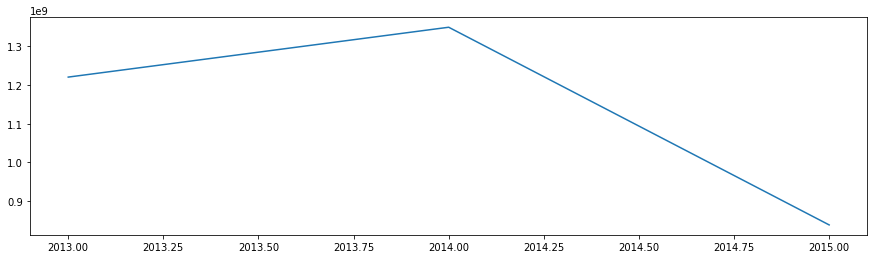

In [13]:
plt.figure(figsize=(15,4))
plt.plot([2013,2014,2015], [train[train['date_year']==year]['revenue_month'].sum() for year in [2013, 2014, 2015]])
plt.show()

## Total revenue by `date_block_num`
* `0` at x axis = `Jan 2013`
* `33` at x axis = `Oct 2015`

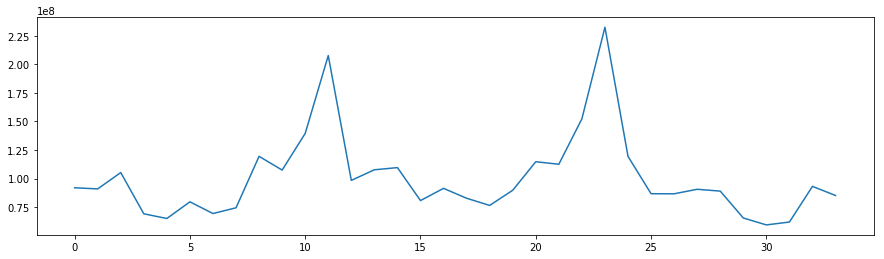

In [14]:
plt.figure(figsize=(15, 4))
plt.plot(sorted(train['date_block_num'].unique()), train.groupby('date_block_num')['revenue_month'].sum())
plt.show()

## Total revenue by `date_month`

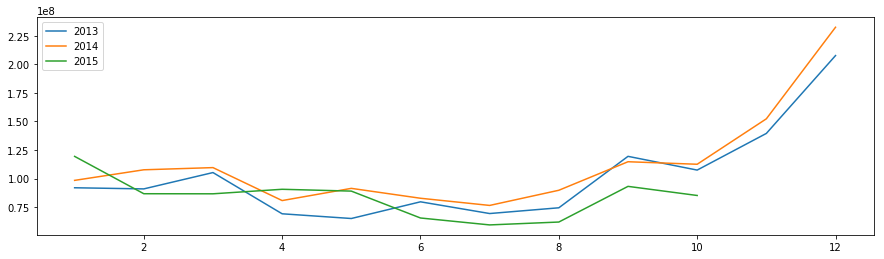

In [15]:
rev_2013_by_month = train[train['date_year']==2013].groupby('date_month')['revenue_month'].sum()
rev_2014_by_month = train[train['date_year']==2014].groupby('date_month')['revenue_month'].sum()
rev_2015_by_month = train[train['date_year']==2015].groupby('date_month')['revenue_month'].sum()

plt.figure(figsize=(15,4))
plt.plot(range(1,13), rev_2013_by_month, label='2013')
plt.plot(range(1,13), rev_2014_by_month, label='2014')
plt.plot(range(1,11), rev_2015_by_month, label='2015')
plt.legend()
plt.show()

## If comparing total revenue from only `Jan` to `Oct` for year `2013`, `2014` and `2015`

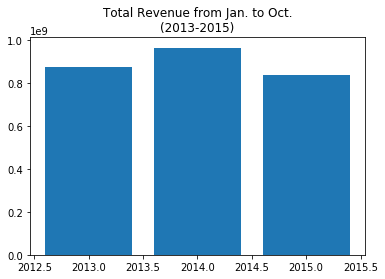

In [16]:
plt.bar([2013,2014,2015], height=[sum(rev_2013_by_month[:10]), sum(rev_2014_by_month[:10]), sum(rev_2015_by_month)])
plt.title('Total Revenue from Jan. to Oct.\n(2013-2015)')
plt.show()

## What happend in Russia of `2015`?

* In `2015`, the total revenue before `Nov` - winter season - decreased relatively.
* From the national economy indices, we can guess the decrease in revenue due to the economical depression.

SOURCE : https://www.focus-economics.com/countries/russia

![russia-economy-indices](data/russia-economy.png)


## Visualize `Revenue in Jan-Oct` with economic index

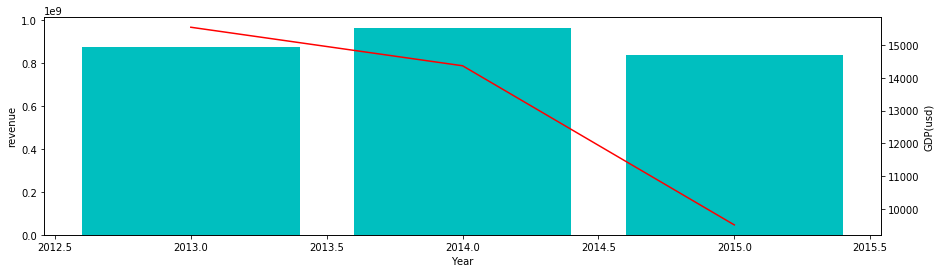

In [17]:
import numpy
def two_scales(ax1, time, data1, data2, c1, c2):
    ax2 = ax1.twinx()

    ax1.bar(time, height=data1, color=c1)
    ax2.plot(time, data2, color=c2)
    
    return ax1, ax2

# Create axes
fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(4)
ax1, ax2 = two_scales(ax, [2013, 2014, 2015], 
                      [sum(rev_2013_by_month[:10]), sum(rev_2014_by_month[:10]), sum(rev_2015_by_month)],
                      [15553, 14374, 9503], 'c', 'r')
ax1.set_xlabel('Year')
ax1.set_ylabel('revenue')
ax2.set_ylabel('GDP(usd)')

plt.show()

In [18]:
# economic index list (in order)
# economic indices tend to be correlated highly.
# we will choose the best feature out of the economic indices.

# gdp_per_capita_usd
# economic_growth_perc
# consumption_perc
# retail_sales_perc
# unemployment_rate
# inflation_rate_cpi_perc
# inflation_rate_ppi_perc

years = [2013, 2014, 2015]
gdp_per_capita_usd = [15553, 14374, 9503]
economic_growth_perc = [1.3, 0.7, -2.8]
consumption_perc = [4.4, 2.0, -9.8]
retail_sales_perc = [3.9, 2.7, -9.8]
unemployment_rate = [5.5, 5.2, 5.6]
inflation_rate_cpi_perc = [6.8, 7.8, 15.5]
inflation_rate_ppi_perc = [3.7, 5.9, 10.7]

eco_indices_names = ['gdp_per_capita_usd', 'economic_growth_perc',
                    'consumption_growth_perc', 'retail_sales_perc',
                    'unemployment_rate', 'inflation_rate_cpi_perc',
                    'inflation_rate_ppi_perc']
eco_indices_values = [
    [15553, 14374, 9503],
    [1.3, 0.7, -2.8],
    [4.4, 2.0, -9.8],
    [3.9, 2.7, -9.8],
    [5.5, 5.2, 5.6],
    [6.8, 7.8, 15.5],
    [3.7, 5.9, 10.7]
]


In [19]:
for i, indexname in enumerate(eco_indices_names):
    
    train[indexname] = train['date_year'].map(dict(zip(years, eco_indices_values[i])))
    #print(len(train[indexname]))

In [20]:
train.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price_month,date_month,date_year,item_category_id,shop_loc,shop_loc_dist,...,item_first_category,date_season,revenue_month,gdp_per_capita_usd,economic_growth_perc,consumption_growth_perc,retail_sales_perc,unemployment_rate,inflation_rate_cpi_perc,inflation_rate_ppi_perc
0,0,30,1,31,265.0,2,2013,40,yakutsk,Far East,...,cinema,winter,8215.0,15553,1.3,4.4,3.9,5.5,6.8,3.7
1,0,31,1,11,434.0,2,2013,37,yakutsk,Far East,...,cinema,winter,4774.0,15553,1.3,4.4,3.9,5.5,6.8,3.7
2,0,32,0,6,221.0,1,2013,40,yakutsk,Far East,...,cinema,winter,1326.0,15553,1.3,4.4,3.9,5.5,6.8,3.7
3,0,32,1,10,221.0,2,2013,40,yakutsk,Far East,...,cinema,winter,2210.0,15553,1.3,4.4,3.9,5.5,6.8,3.7
4,0,33,0,3,347.0,1,2013,37,yakutsk,Far East,...,cinema,winter,1041.0,15553,1.3,4.4,3.9,5.5,6.8,3.7


## Where is the hottest area?
* Top 10 areas by total `revenue`

In [47]:
def draw_sorted_barplot_with_groupby(groupby_col, agg_col, aggfunc, 
                                     idx_init = None, 
                                     idx=(None,None), 
                                     figsize=None,
                                     draw_avgline=False):
    
    if idx_init is not None:
        df_grouped = train[idx_init].groupby([groupby_col])[agg_col].apply(aggfunc).reset_index()
    else:
        df_grouped = train.groupby([groupby_col])[agg_col].apply(aggfunc).reset_index()
    
    df_grouped.fillna(0, inplace=True)
    
    agg_sorted = df_grouped[agg_col].sort_values(ascending=False).tolist()

    mapping = {ag: i for i, ag in enumerate(agg_sorted)}
    key = df_grouped[agg_col].map(mapping)
    df_grouped = df_grouped.iloc[key.argsort()]
    
    if idx[0] or idx[1]:
        df_grouped = df_grouped.iloc[idx[0]:idx[1]]
    
    ax = df_grouped.plot(kind='bar', x=groupby_col, y=agg_col, figsize=figsize)
    
    if draw_avgline:
        ax.axhline(y = df_grouped[agg_col].mean(),
                  color = 'r', linestyle='--', label='average_line')
    plt.legend()
    plt.show()

* `shop`s in `moscow` show an outstanding total revenue among all `shop_loc`s.

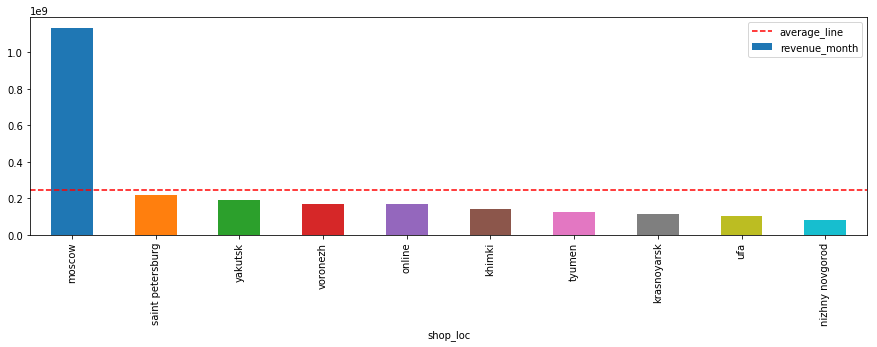

In [22]:
draw_sorted_barplot_with_groupby('shop_loc', 'revenue_month', 
                                 sum, idx=(None,10), figsize=(15,4), draw_avgline=1)

### Total revenue from all `shop_loc`s except for `moscow`


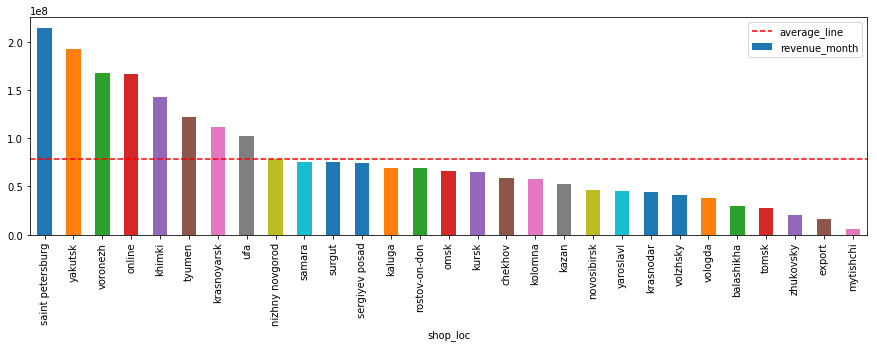

In [23]:
draw_sorted_barplot_with_groupby('shop_loc', 'revenue_month', 
                                 sum, idx=(1,None), figsize=(15,4), draw_avgline=1)

## Number of unique `shop_id`s by `shop_loc`

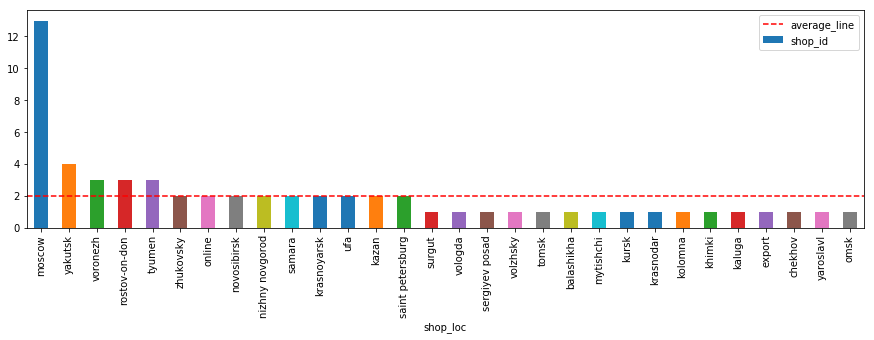

In [40]:
draw_sorted_barplot_with_groupby('shop_loc', 'shop_id', 
                                 lambda x: len(x.unique()), idx=(None,None), figsize=(15,4), draw_avgline=1)

### Number of unique `shop_id`s by `shop_loc` - except for `moscow`

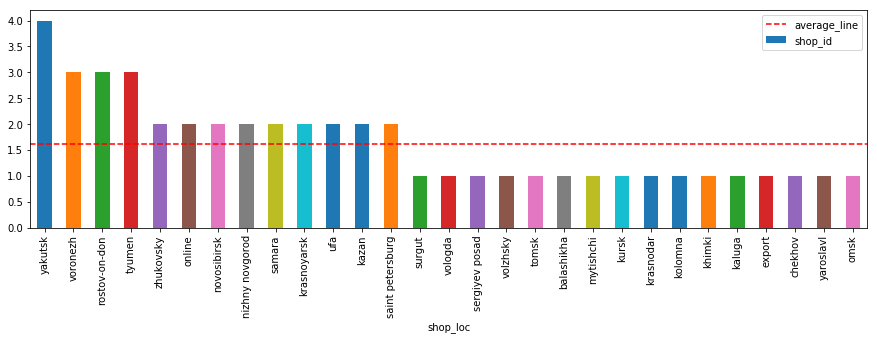

In [25]:
draw_sorted_barplot_with_groupby('shop_loc', 'shop_id', 
                                 lambda x: len(x.unique()), idx=(1,None), figsize=(15,4), draw_avgline=1)

## Top 10 areas with total `revenue` per shop

* `export` and `online` take first & second
* Since `export` and `online` are not exactly the physical 'location' where one shop is located in - we can exclude them from the graph.

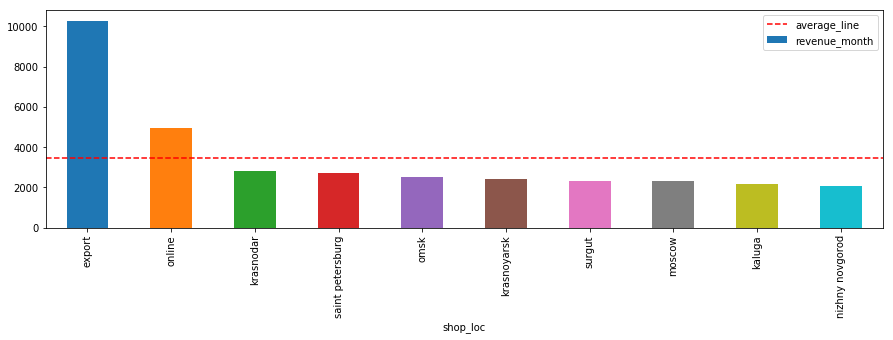

In [26]:
draw_sorted_barplot_with_groupby('shop_loc', 'revenue_month', 
                                 lambda x: x.mean(), idx=(None,10), figsize=(15,4), draw_avgline=1)

### Top 10 areas with total `revenue` per shop 
### If excluding `export` and `online`

* shops in `moscow` have the most revenue & number of shops, but not the revenue per shop.

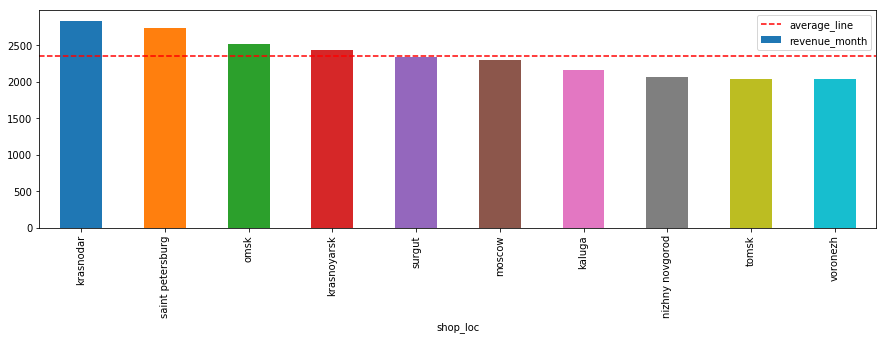

In [28]:
draw_sorted_barplot_with_groupby('shop_loc', 'revenue_month', 
                                 lambda x: x.mean(), idx=(2,12), figsize=(15,4), draw_avgline=1)

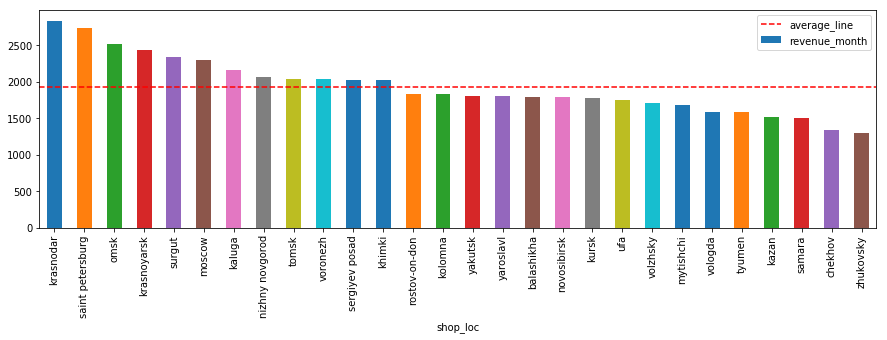

In [29]:
draw_sorted_barplot_with_groupby('shop_loc', 'revenue_month', 
                                 lambda x: x.mean(), idx=(2,None), figsize=(15,4), draw_avgline=1)

## Top 10 shops in terms of `revenue`

In [27]:
total_revenue_by_store = train.groupby('shop_id')['revenue_month'].sum().sort_values(ascending=False)
plt.figure(figsize=(15, 5))
total_revenue_by_store[:10]

shop_id
31    235595600.0
25    216867424.0
28    159948672.0
42    152203136.0
54    142133440.0
27    140757120.0
12    116575208.0
57    113132040.0
6      98277800.0
18     83525976.0
Name: revenue_month, dtype: float32

### `moscow` has 4 `shop`s out of top 10 `shop`s by total `revenue`

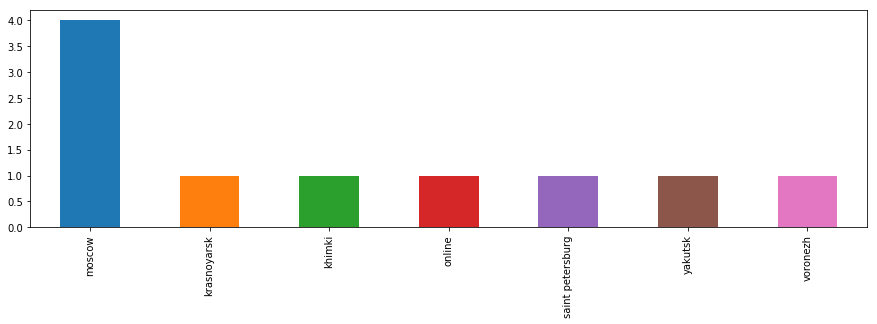

In [28]:
top10shop_locs = [train[train['shop_id'] == topshop_id]['shop_loc'].unique()[0] for topshop_id in total_revenue_by_store[:10].index]
pd.Series(top10shop_locs).value_counts().plot(kind='bar', x='shop_loc', y='number of shops', figsize=(15,4));plt.show()

## What category has been sold in terms of `revenue`?

### Game, Game, Game!
* `games` (= console games), `game consoles`, `pc games` rank top 3
* Categories related with game - `games`, `game consoles`, `pc games`, `android games`

### Categories related with game take `63.5%` from total `revenue` in entire period.

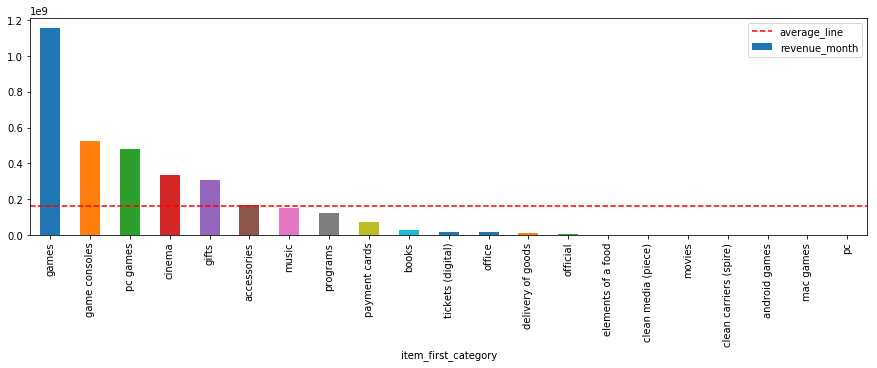

In [29]:
draw_sorted_barplot_with_groupby('item_first_category', 
                                 'revenue_month', 
                                 sum, idx=(None,None), 
                                 figsize=(15,4), 
                                 draw_avgline=1)

In [33]:
games_rel_cats = ['games', 'game consoles', 'pc games', 'android games']
total_rev = train['revenue_month'].sum()
total_rev_from_game = train[['item_first_category', 'revenue_month']].groupby('item_first_category').sum().loc[games_rel_cats].sum().values[0]

print(total_rev_from_game/total_rev*100)

63.5147094727


## What category has been sold the most? (`item_cnt_month`)

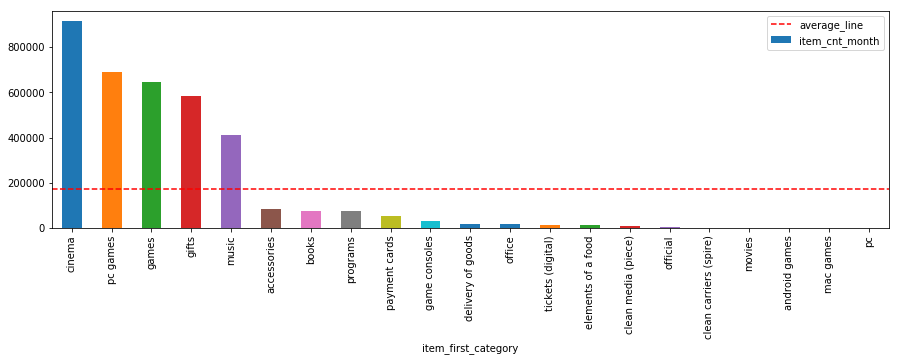

In [30]:
draw_sorted_barplot_with_groupby('item_first_category', 'item_cnt_month', 
                                 sum, idx=(None,None), figsize=(15,4), draw_avgline=1)

## If we categorize shops by their major products (=`products making the most revenue`)?

In [31]:
shop_item_category_sales = train.groupby(['shop_id', 'item_first_category'])['revenue_month'].sum()
major_categories = []

for shopid in range(60):
    top3_items = shop_item_category_sales[shopid].sort_values(ascending=False).index.tolist()[:3]
    major_categories.append(top3_items)
    
# top3 item categories by their sales for each store (id)
dict(zip(range(60), major_categories))

{0: ['games', 'game consoles', 'cinema'],
 1: ['games', 'game consoles', 'cinema'],
 2: ['games', 'game consoles', 'pc games'],
 3: ['games', 'game consoles', 'pc games'],
 4: ['games', 'pc games', 'game consoles'],
 5: ['games', 'game consoles', 'pc games'],
 6: ['games', 'pc games', 'game consoles'],
 7: ['games', 'game consoles', 'pc games'],
 8: ['games', 'pc games', 'cinema'],
 9: ['gifts', 'games', 'pc games'],
 10: ['games', 'pc games', 'game consoles'],
 11: ['games', 'game consoles', 'pc games'],
 12: ['games', 'game consoles', 'pc games'],
 13: ['cinema', 'games', 'music'],
 14: ['games', 'pc games', 'game consoles'],
 15: ['games', 'pc games', 'game consoles'],
 16: ['games', 'game consoles', 'pc games'],
 17: ['games', 'game consoles', 'cinema'],
 18: ['games', 'game consoles', 'pc games'],
 19: ['games', 'pc games', 'game consoles'],
 20: ['gifts', 'books', 'elements of a food'],
 21: ['games', 'game consoles', 'cinema'],
 22: ['games', 'programs', 'pc games'],
 23: ['pc g

## Finding the hottest item for entire periods

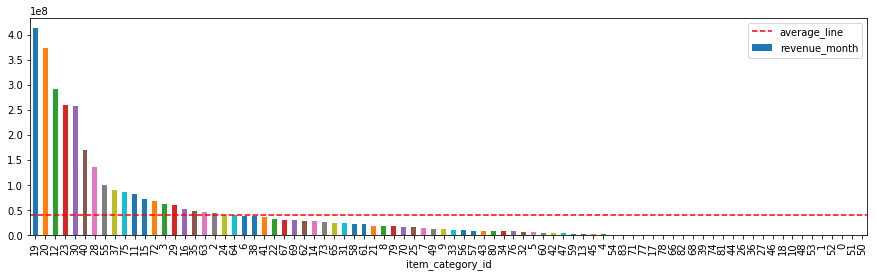

In [36]:
draw_sorted_barplot_with_groupby('item_category_id', 
                                 'revenue_month', 
                                 sum, 
                                 idx=(None,None), 
                                 figsize=(15,4), 
                                 draw_avgline=1)

* It's hard to acknowledge which number is which item.
* For better visualization, we modify `item_category_id` column.

In [55]:
train_to_extract_cols = pd.read_csv('data/sales_train_opt_ver1.csv')
train_to_extract_cols.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price_month,date_month,date_year,item_cateogory_id,shop_loc,shop_loc_dist,shop_loc_pop_2010,shop_loc_pop_2017,shop_loc_pop_rank_2017,shop_loc_pop_change_2010_2017,item_first_category,item_second_category
0,0,30,1,31.0,265.0,2,2013,40,yakutsk,Far East,269601.0,307911.0,64.0,14.2,cinema,dvd
1,0,31,1,11.0,434.0,2,2013,37,yakutsk,Far East,269601.0,307911.0,64.0,14.2,cinema,blu-ray
2,0,32,0,6.0,221.0,1,2013,40,yakutsk,Far East,269601.0,307911.0,64.0,14.2,cinema,dvd
3,0,32,1,10.0,221.0,2,2013,40,yakutsk,Far East,269601.0,307911.0,64.0,14.2,cinema,dvd
4,0,33,0,3.0,347.0,1,2013,37,yakutsk,Far East,269601.0,307911.0,64.0,14.2,cinema,blu-ray


In [56]:
train['item_category_id_withstring'] = train_to_extract_cols['item_first_category'] + train_to_extract_cols['item_cateogory_id'].apply(lambda x: str(x))

In [57]:
print(sorted(train['item_category_id'].unique().tolist()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]


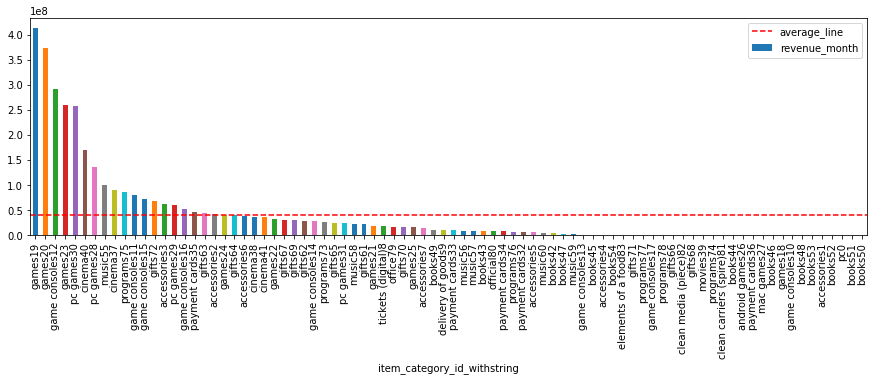

In [58]:
draw_sorted_barplot_with_groupby('item_category_id_withstring', 
                                 'revenue_month', 
                                 sum, 
                                 idx=(None,None), 
                                 figsize=(15,4), 
                                 draw_avgline=1)

### Top 10 Best-sellers by year (2013, 2014, 2015)

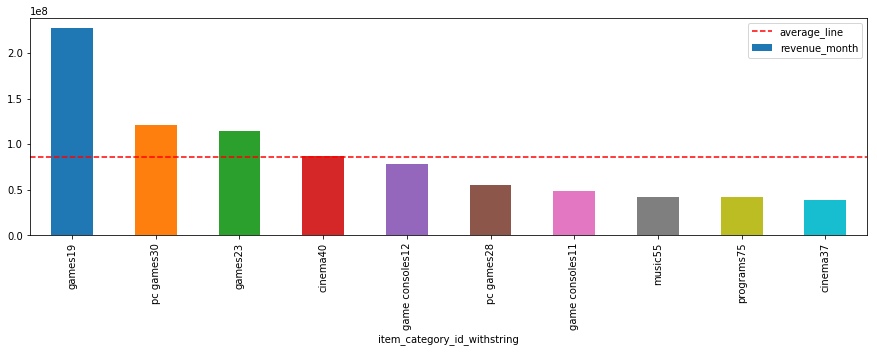

In [60]:
draw_sorted_barplot_with_groupby('item_category_id_withstring', 
                                 'revenue_month', 
                                 sum, 
                                 idx_init = train['date_year']==2013,
                                 idx=(None,10), 
                                 figsize=(15,4), 
                                 draw_avgline=1)

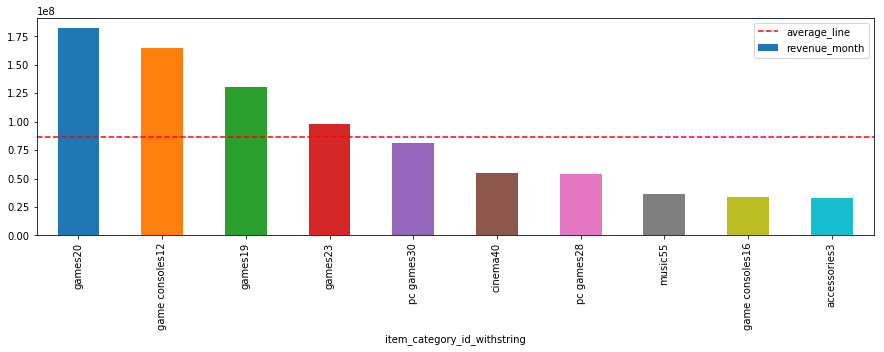

In [61]:
draw_sorted_barplot_with_groupby('item_category_id_withstring', 
                                 'revenue_month', 
                                 sum, 
                                 idx_init = train['date_year']==2014,
                                 idx=(None,10), 
                                 figsize=(15,4), 
                                 draw_avgline=1)

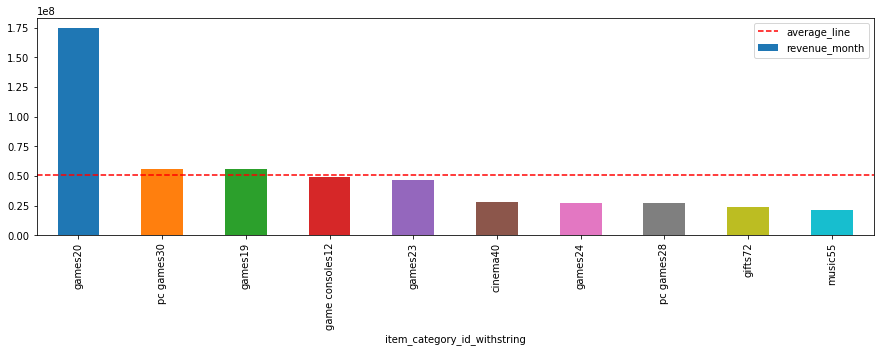

In [62]:
draw_sorted_barplot_with_groupby('item_category_id_withstring', 
                                 'revenue_month', 
                                 sum, 
                                 idx_init = train['date_year']==2015,
                                 idx=(None,10), 
                                 figsize=(15,4), 
                                 draw_avgline=1)

### Top 10 categories

* It is absolutely not surprising that game-related categories rank 1st-5th.

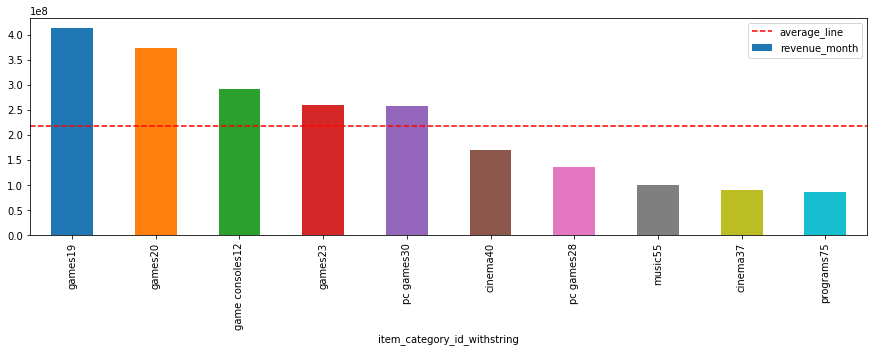

In [40]:
draw_sorted_barplot_with_groupby('item_category_id_withstring', 'revenue_month', 
                                 sum, idx=(None,10), figsize=(15,4), draw_avgline=1)

### Entire categories

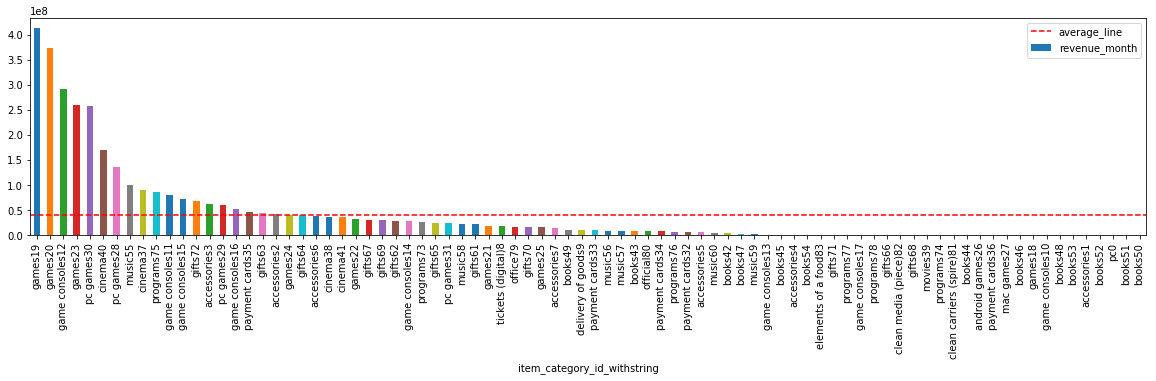

In [41]:
draw_sorted_barplot_with_groupby('item_category_id_withstring', 'revenue_month', 
                                 sum, idx=(None,None), figsize=(20,4), draw_avgline=1)

### Multiple plots in-depth
- Let's plot the changes in sales amount for the best-selling items by year-month.

In [165]:
best_seller_top10_ids = train.groupby('item_category_id_withstring')['revenue_month'].sum().sort_values(ascending=False)[:10].index.tolist()

In [166]:
best_seller_top10_ids

['games19',
 'games20',
 'game consoles12',
 'games23',
 'pc games30',
 'cinema40',
 'pc games28',
 'music55',
 'cinema37',
 'programs75']

### Note.
* We can see the strong difference between `game` related categories and `non-game` categories
  1. Demand for `non-game` items usually decreased over time - highest in the early stage.
    * This means consumers tend to prefer `cinema`/`music` in the latest.
  2. Demand for `game` items usually have multi-modality; best selling games seem to have various influences other than time.
    * This means consumers tend to prefer `game` well-known and known as 'well-made' - relatively regardless of time.

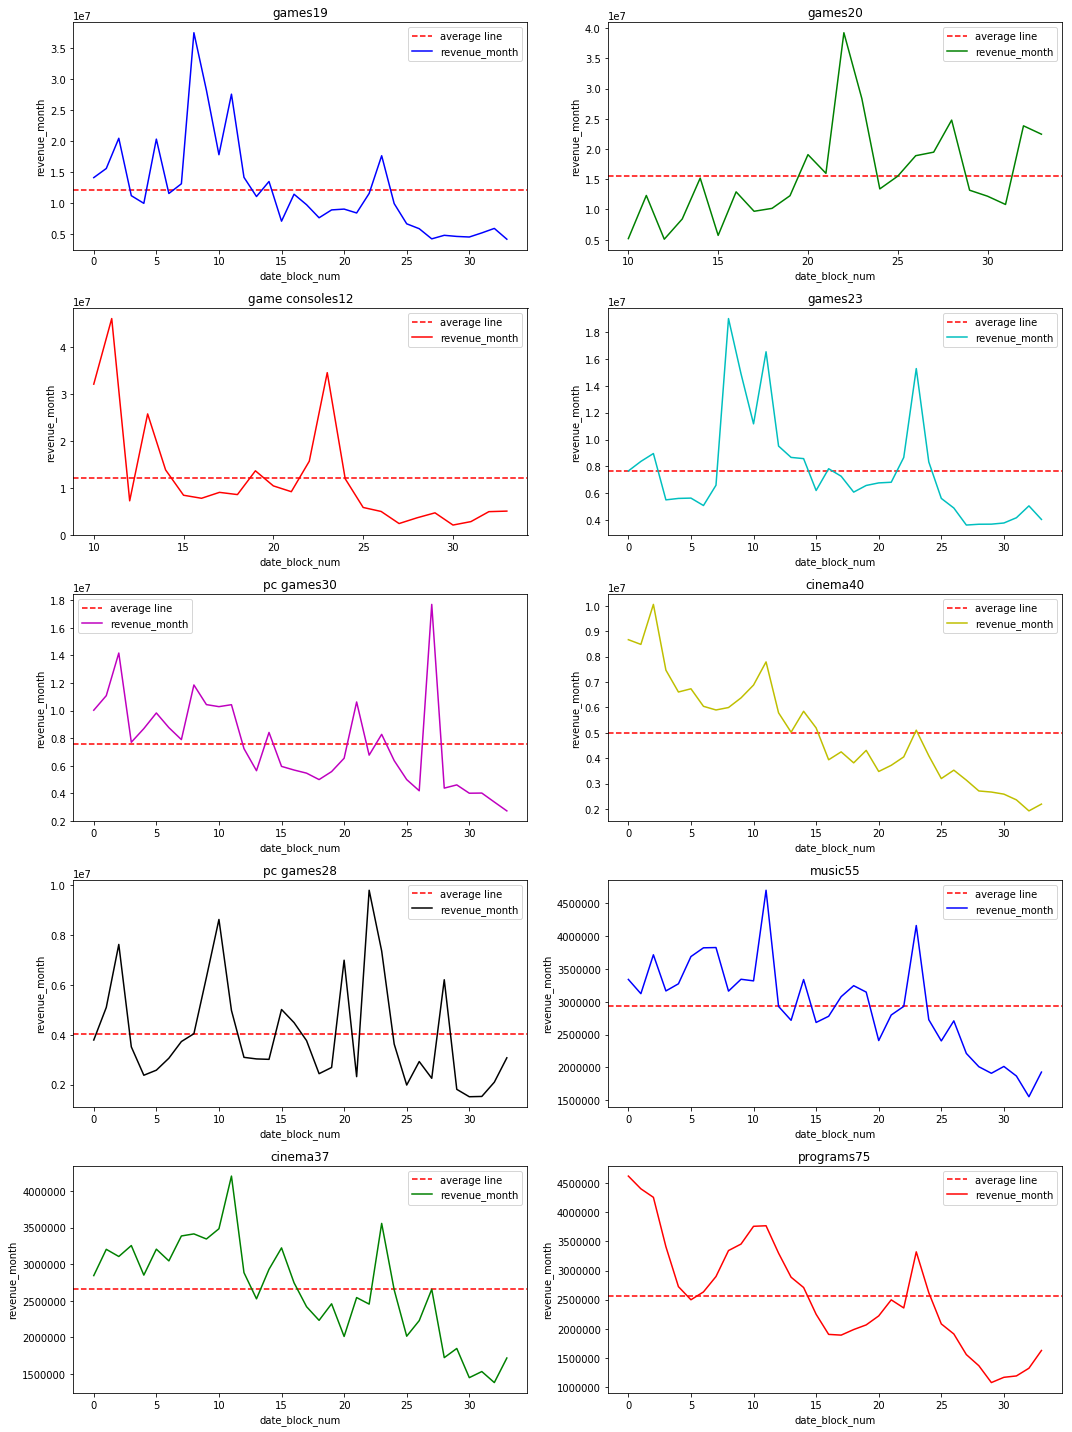

In [44]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r']
fig = plt.figure(figsize=(15,20))

for i, best_seller_id in enumerate(best_seller_top10_ids):
    item_sales_trend = train[train['item_category_id_withstring'] == best_seller_id].groupby('date_block_num')['revenue_month'].sum()
    ax = fig.add_subplot(5, 2, i+1)
    ax.axhline(y=item_sales_trend.mean(), c='r', label='average line', linestyle='--')
    ax.set_title(best_seller_id)
    ax.set_xlabel('date_block_num')
    ax.set_ylabel('revenue_month')
    ax.plot(item_sales_trend.index, item_sales_trend.values, color=colors[i], label='revenue_month')
    ax.legend()
plt.tight_layout()
plt.show()

## Find different seasonal effects on different categories

In [98]:
category_id_num_blocks = {}
original_dict = dict(zip(train['item_category_id'], train['item_first_category']))
original_dict

{0: 'pc',
 1: 'accessories',
 2: 'accessories',
 3: 'accessories',
 4: 'accessories',
 5: 'accessories',
 6: 'accessories',
 7: 'accessories',
 8: 'tickets (digital)',
 9: 'delivery of goods',
 10: 'game consoles',
 11: 'game consoles',
 12: 'game consoles',
 13: 'game consoles',
 14: 'game consoles',
 15: 'game consoles',
 16: 'game consoles',
 17: 'game consoles',
 18: 'games',
 19: 'games',
 20: 'games',
 21: 'games',
 22: 'games',
 23: 'games',
 24: 'games',
 25: 'games',
 26: 'android games',
 27: 'mac games',
 28: 'pc games',
 29: 'pc games',
 30: 'pc games',
 31: 'pc games',
 32: 'payment cards',
 33: 'payment cards',
 34: 'payment cards',
 35: 'payment cards',
 36: 'payment cards',
 37: 'cinema',
 38: 'cinema',
 39: 'movies',
 40: 'cinema',
 41: 'cinema',
 42: 'books',
 43: 'books',
 44: 'books',
 45: 'books',
 46: 'books',
 47: 'books',
 48: 'books',
 49: 'books',
 50: 'books',
 51: 'books',
 52: 'books',
 53: 'books',
 54: 'books',
 55: 'music',
 56: 'music',
 57: 'music',
 5

In [99]:
original_dict[0] = 'accessories'
original_dict[39] = 'cinema'

In [100]:
for key, value in original_dict.items():
    
    if value in category_id_num_blocks:
        category_id_num_blocks[value] += [key]
    
    else:
        category_id_num_blocks[value] = [key]
        
    category_id_num_blocks[value] = sorted(category_id_num_blocks[value])
        
category_id_num_blocks

{'accessories': [0, 1, 2, 3, 4, 5, 6, 7],
 'android games': [26],
 'books': [42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54],
 'cinema': [37, 38, 39, 40, 41],
 'clean carriers (spire)': [81],
 'clean media (piece)': [82],
 'delivery of goods': [9],
 'elements of a food': [83],
 'game consoles': [10, 11, 12, 13, 14, 15, 16, 17],
 'games': [18, 19, 20, 21, 22, 23, 24, 25],
 'gifts': [61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72],
 'mac games': [27],
 'music': [55, 56, 57, 58, 59, 60],
 'office': [79],
 'official': [80],
 'payment cards': [32, 33, 34, 35, 36],
 'pc games': [28, 29, 30, 31],
 'programs': [73, 74, 75, 76, 77, 78],
 'tickets (digital)': [8]}

In [130]:
def plot_monthly_rev_by_category_id(category_ids):
    plt.figure(figsize=(15,4))
    
    for catid in category_ids:
        cat_index = train['item_category_id'] == catid
        item_monthly_revs = train[cat_index].groupby('date_block_num')['revenue_month'].sum()
        container_arr = [None]*34
        
        for i, rev in zip(item_monthly_revs.index, item_monthly_revs):
            container_arr[i] = rev
            
        plt.plot(range(34), container_arr, label=catid)
    
    plt.legend()
    plt.show()

category : accessories // approximate marketsize : 166407360.0


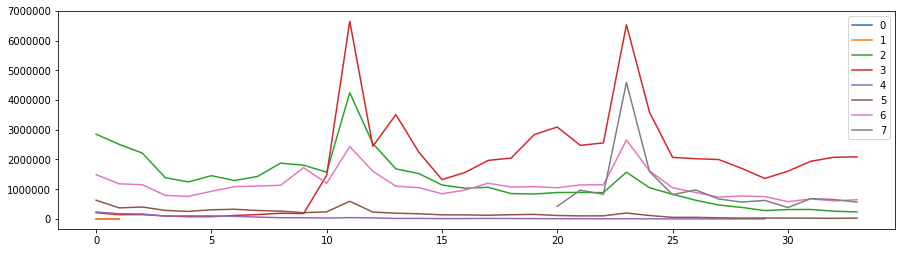

In [192]:
print('category : accessories // approximate marketsize : {}'.format(train[train['item_first_category']=='accessories']['revenue_month'].sum()))
plot_monthly_rev_by_category_id(category_id_num_blocks['accessories'])

category : game consoles // approximate marketsize : 527840128.0


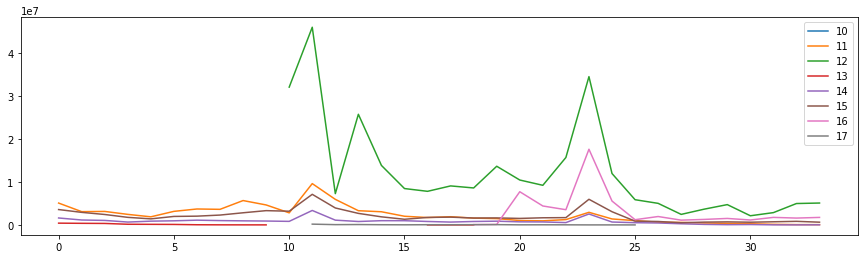

In [193]:
print('category : game consoles // approximate marketsize : {}'.format(train[train['item_first_category']=='game consoles']['revenue_month'].sum()))
plot_monthly_rev_by_category_id(category_id_num_blocks['game consoles'])

category : games // approximate marketsize : 1157038336.0


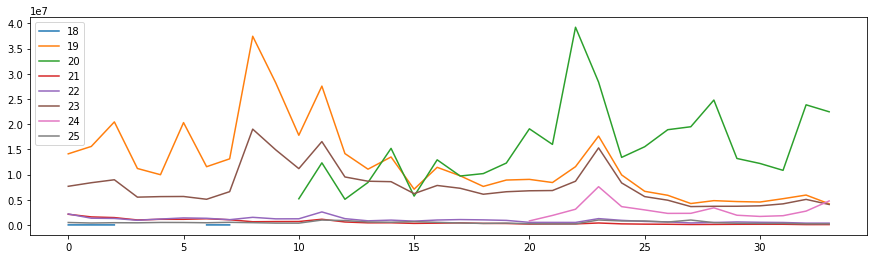

In [194]:
print('category : games // approximate marketsize : {}'.format(train[train['item_first_category']=='games']['revenue_month'].sum()))
plot_monthly_rev_by_category_id(category_id_num_blocks['games'])

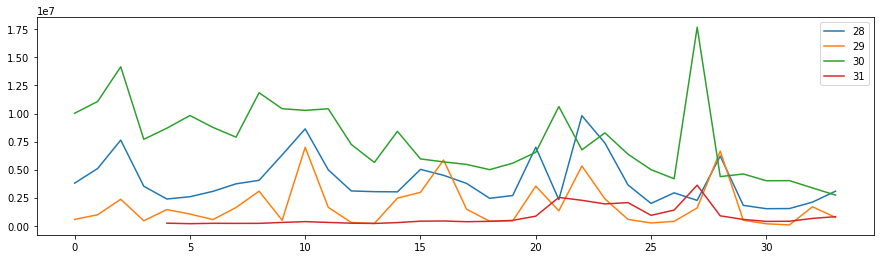

In [149]:
plot_monthly_rev_by_category_id(category_id_num_blocks['pc games'])

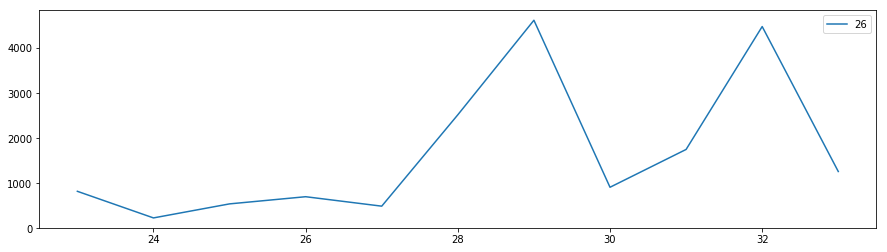

In [135]:
plot_monthly_rev_by_category_id(category_id_num_blocks['android games'])

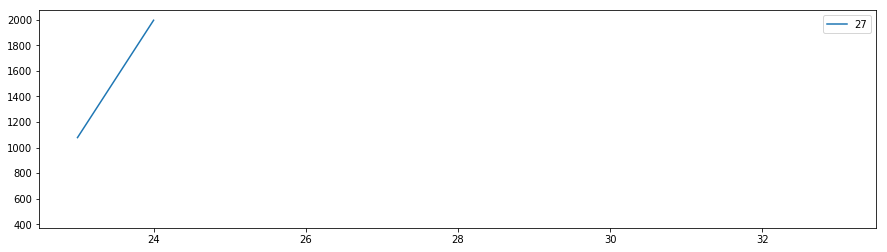

In [136]:
plot_monthly_rev_by_category_id(category_id_num_blocks['mac games'])

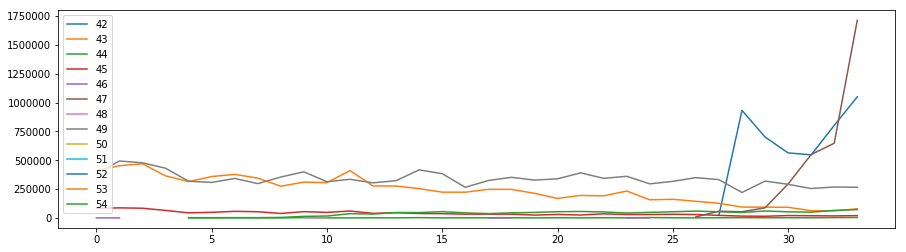

In [143]:
plot_monthly_rev_by_category_id(category_id_num_blocks['books'])

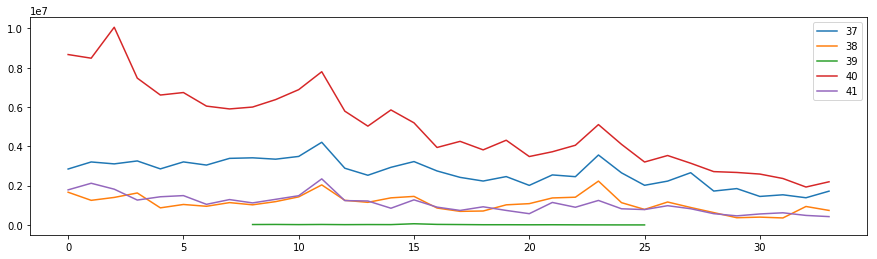

In [139]:
plot_monthly_rev_by_category_id(category_id_num_blocks['cinema'])

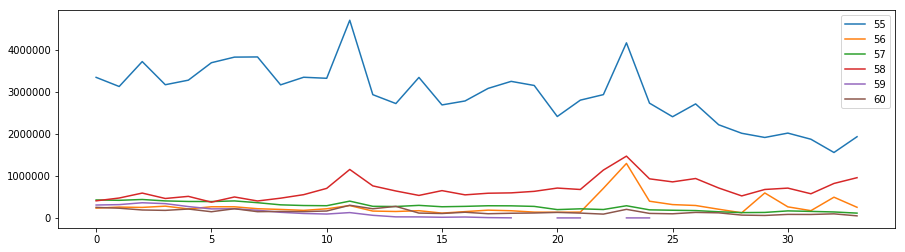

In [140]:
plot_monthly_rev_by_category_id(category_id_num_blocks['music'])

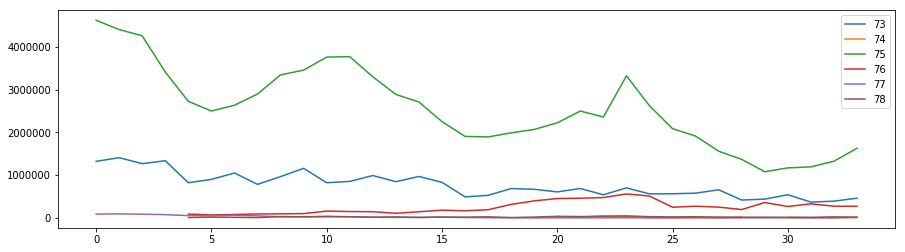

In [144]:
plot_monthly_rev_by_category_id(category_id_num_blocks['programs'])

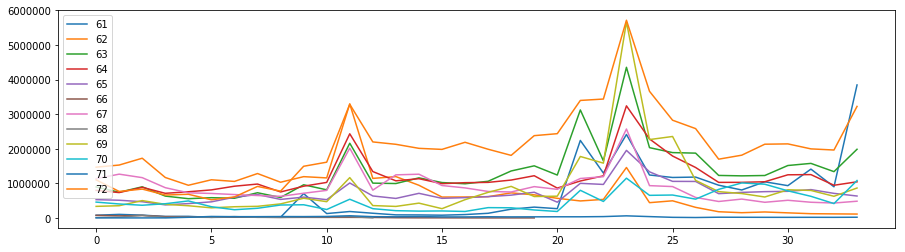

In [145]:
plot_monthly_rev_by_category_id(category_id_num_blocks['gifts'])

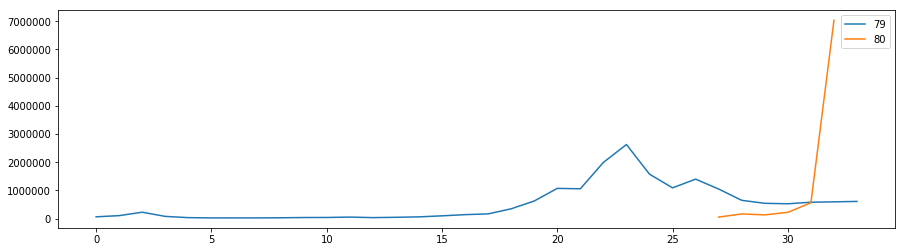

In [147]:
plot_monthly_rev_by_category_id(category_id_num_blocks['office']+\
                               category_id_num_blocks['official']) # id 79 for 'office', id 80 for 'official'

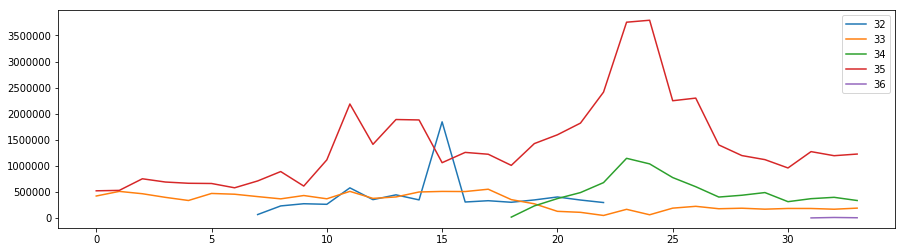

In [148]:
plot_monthly_rev_by_category_id(category_id_num_blocks['payment cards'])

* We can combine `item_category_id` `81` and `82` since they show almost same pattern

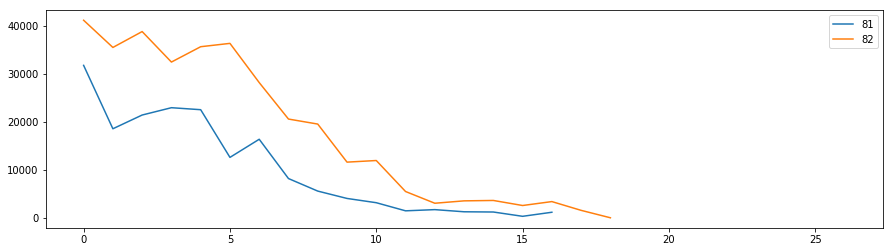

In [160]:
plot_monthly_rev_by_category_id(category_id_num_blocks['clean carriers (spire)']+\
                               category_id_num_blocks['clean media (piece)']) # id 81 for 'clean carriers~', 
                                                                              # id 82 for 'clean media~'
    
original_dict[81] = 'clean carriers'
original_dict[82] = 'clean carriers'

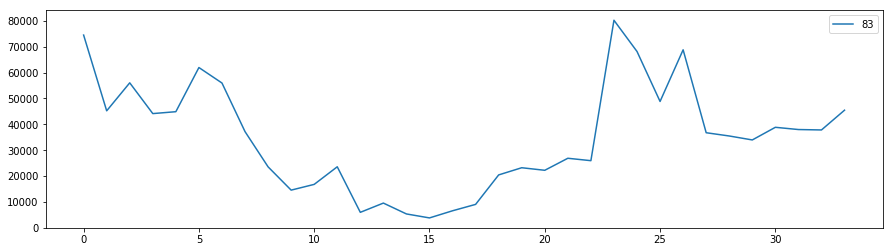

In [151]:
plot_monthly_rev_by_category_id(category_id_num_blocks['elements of a food'])

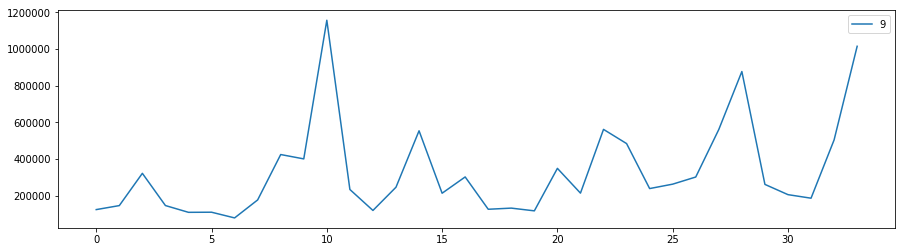

In [152]:
plot_monthly_rev_by_category_id(category_id_num_blocks['delivery of goods'])

In [161]:
# update the feature 'item_first_category'
train['item_first_category'] = train['item_category_id'].map(original_dict)

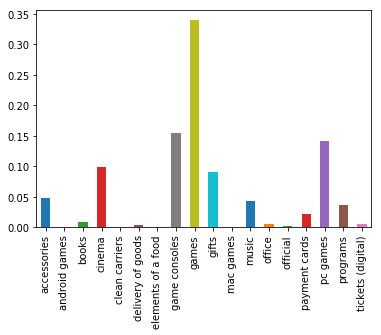

In [197]:
# show the market size for each category

total_marketsize = train['revenue_month'].sum()
marketsize_by_cat = {}

for first_catname in train['item_first_category'].unique():
    
    marketsize = train[train['item_first_category']==first_catname]['revenue_month'].sum()
    marketsize_by_cat[first_catname] = marketsize / total_marketsize

pd.Series(marketsize_by_cat).plot(kind='bar')
plt.show()

## Finding the 'hot months' for each product

We can define, `on_trend` in `[True, False]` in the standard below: 
* `True` : if the revenue at each month is bigger than the average revenue by 20% or more ( `> 1.2 * average revenue`)
* `False` : else
* **There possibly exist some products having multiple `hot period`**.


In [167]:
def calc_hot_period(id_withstring):
    
    prod_revenues = train[train['item_category_id_withstring']==id_withstring].groupby('date_block_num')['revenue_month'].sum()
    #print(prod_revenues[:5])
    
    hot_period_months = []
    hot_period_revenues = []
    mean_revenue_month = prod_revenues.mean()

    for (rev, block) in zip(prod_revenues, prod_revenues.index):
        
        if rev > 1.2 * mean_revenue_month:
            #print('hot')
            hot_period_months.append(block)
            hot_period_revenues.append(rev)
            
    return id_withstring, hot_period_months, hot_period_revenues

### test the function with `best_seller_top10_ids`

In [168]:
best_seller_top10_ids_periods = []

for bs_top10_id in best_seller_top10_ids:
    
    pid, periods, revs = calc_hot_period(bs_top10_id)
    best_seller_top10_ids_periods.append((pid, periods, revs))

In [169]:
print(best_seller_top10_ids_periods)

[('games19', [1, 2, 5, 8, 9, 10, 11, 23], [15573964.0, 20440654.0, 20300814.0, 37435580.0, 28175302.0, 17789694.0, 27540902.0, 17628990.0]), ('games20', [20, 22, 23, 26, 27, 28, 32, 33], [19067990.0, 39221800.0, 28337492.0, 18892098.0, 19478344.0, 24778114.0, 23829664.0, 22446386.0]), ('game consoles12', [10, 11, 13, 22, 23], [32130506.0, 46096188.0, 25798660.0, 15726716.0, 34579548.0]), ('games23', [8, 9, 10, 11, 12, 23], [19004656.0, 14890428.0, 11169339.0, 16532606.0, 9514174.0, 15281760.0]), ('pc games30', [0, 1, 2, 5, 8, 9, 10, 11, 21, 27], [10022902.0, 11079526.0, 14168866.0, 9824922.0, 11854610.0, 10430254.0, 10282350.0, 10423895.0, 10621765.0, 17694588.0]), ('cinema40', [0, 1, 2, 3, 4, 5, 6, 9, 10, 11], [8667498.0, 8482258.0, 10056494.0, 7467619.5, 6607698.5, 6734576.0, 6044333.5, 6375694.5, 6881728.0, 7793230.5]), ('pc games28', [1, 2, 9, 10, 11, 15, 20, 22, 23, 28], [5100369.5, 7629847.0, 6310472.0, 8631819.0, 4980750.0, 5017894.0, 6996758.5, 9805374.0, 7366110.5, 6212296.0])

### Add 'hot period' to the graph

In [170]:
import numpy as np

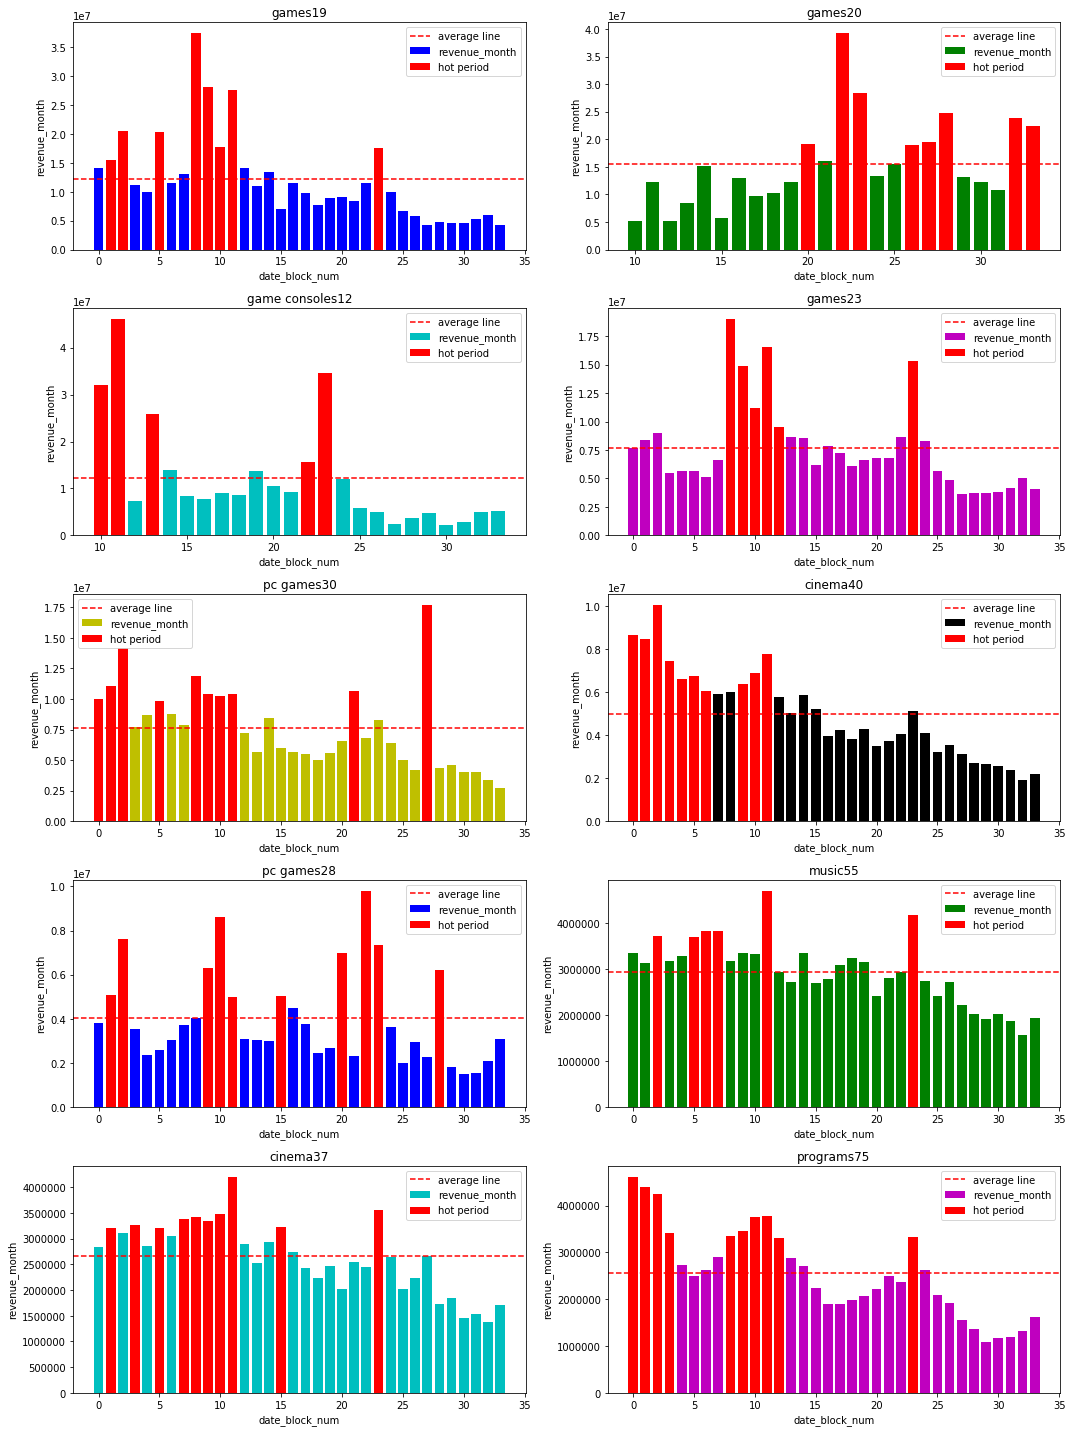

In [171]:
colors = ['b', 'g', 'c', 'm', 'y', 'k', 'b', 'g', 'c', 'm']
fig = plt.figure(figsize=(15,20))

for i, best_seller_id in enumerate(best_seller_top10_ids):
    item_sales_trend = train[train['item_category_id_withstring'] == best_seller_id].groupby('date_block_num')['revenue_month'].sum()
    ax = fig.add_subplot(5, 2, i+1)
    ax.axhline(y=item_sales_trend.mean(), c='r', label='average line', linestyle='--')
    ax.set_title(best_seller_id)
    ax.set_xlabel('date_block_num')
    ax.set_ylabel('revenue_month')
    ax.bar(item_sales_trend.index, item_sales_trend.values, color=colors[i], label='revenue_month')
    
    hot_period_months = best_seller_top10_ids_periods[i][1]
    hot_period_revenues = pd.Series(np.zeros(len(item_sales_trend.index)), index = item_sales_trend.index)
    
    k = 0
    for j in item_sales_trend.index:
        if j in hot_period_months:
            hot_period_revenues.loc[j] = best_seller_top10_ids_periods[i][2][k]
            
            # for debugging
            #if hot_period_revenues.loc[j] != item_sales_trend.loc[j]:
            #    print('Error', best_seller_top10_ids[i], j, hot_period_revenues[j], item_sales_trend.values[j])
            k += 1
    
    ax.bar(item_sales_trend.index, hot_period_revenues, color='r', label='hot period')
    ax.legend()

plt.tight_layout()
plt.show()

## Which months are commonly included in all products in `games` / `non-games` category?
* Find the months frequently occurred in the lists of hot-periods from products
* Add a binary column to categorize `game` or `nongame` as `1`, `0`

In [179]:
import re
train['is_game_category'] = train['item_category_id_withstring'].apply(lambda x: 1 if len(re.findall(r'game', x)) else 0)

In [177]:
def find_important_month(id_withstring_list):
    hot_months_li = []
    
    for id_withstring in id_withstring_list:
        hot_months_li += calc_hot_period(id_withstring)[1]
        
    hot_months_valc = pd.Series(hot_months_li).apply(lambda x: x%13).value_counts()
    
    return hot_months_valc

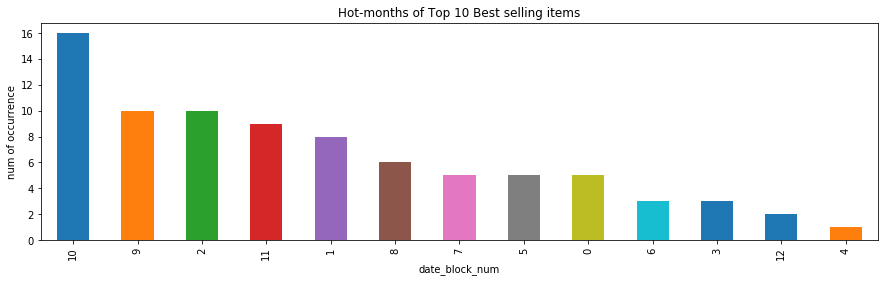

In [178]:
find_important_month(best_seller_top10_ids).plot(kind='bar', figsize=(15,4))
plt.title('Hot-months of Top 10 Best selling items')
plt.ylabel('num of occurrence')
plt.xlabel('date_block_num')
plt.show()

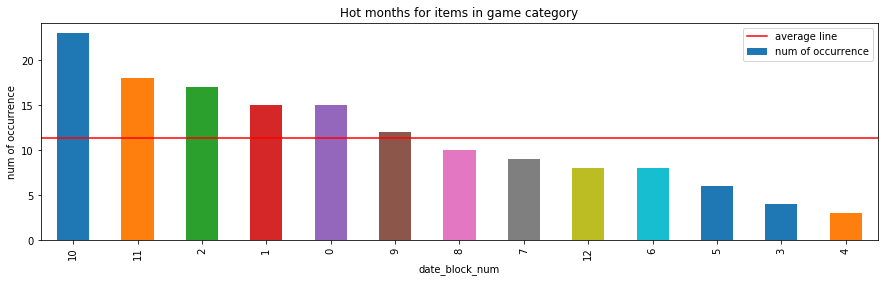

In [180]:
game_cat_ids = train[train['is_game_category']==True]['item_category_id_withstring'].unique().tolist()

find_important_month(game_cat_ids).plot(kind='bar', figsize=(15,4), label='num of occurrence')
plt.axhline(find_important_month(game_cat_ids).mean(), label='average line', c='r')
plt.title('Hot months for items in game category')
plt.ylabel('num of occurrence')
plt.xlabel('date_block_num')
plt.legend()
plt.show()

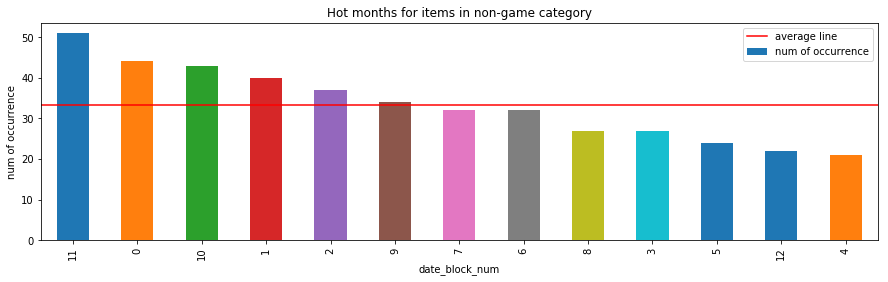

In [181]:
nongame_cat_ids = train[train['is_game_category']==False]['item_category_id_withstring'].unique().tolist()

find_important_month(nongame_cat_ids).plot(kind='bar', figsize=(15,4), label='num of occurrence')
plt.axhline(find_important_month(nongame_cat_ids).mean(), label='average line', c='r')
plt.title('Hot months for items in non-game category')
plt.ylabel('num of occurrence')
plt.xlabel('date_block_num')
plt.legend()
plt.show()

* If we replace 'date_num_block' with 'date_season' as the unit for time,

In [54]:
def calc_hot_period(id_withstring, plus_season=False):
    
    prod_revenues = train[train['item_category_id_withstring']==id_withstring].groupby('date_block_num')['revenue_month'].sum()
    
    hot_period_seasons = []
    hot_period_months = []
    hot_period_revenues = []
    mean_revenue_month = prod_revenues.mean()
    
    month_season_dict = dict(zip(train['date_block_num'],
                                train['date_season']))
    
    for (rev, month) in zip(prod_revenues, prod_revenues.index):
        
        if rev > 1.2 * mean_revenue_month:
            
            hot_period_months.append(month)
            hot_period_revenues.append(rev)
            
            if plus_season:
                season = month_season_dict[month]
                hot_period_seasons.append(season)
                
    if plus_season:
        return id_withstring, hot_period_months, hot_period_seasons, hot_period_revenues
    else:
        return id_withstring, hot_period_months, hot_period_revenues

In [55]:
def find_important_season(id_withstring_list):
    hot_seasons_li = []
    
    for id_withstring in id_withstring_list:
        hot_seasons_li += calc_hot_period(id_withstring, plus_season=1)[2]
        
    hot_seasons_valc = pd.Series(hot_seasons_li).value_counts()
    
    return hot_seasons_valc

In [56]:
# test.
find_important_season(['games19'])

autumn    3
winter    3
summer    1
spring    1
dtype: int64

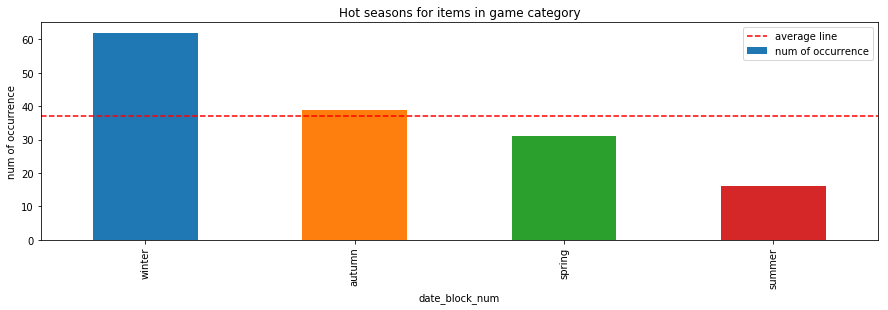

In [57]:
find_important_season(game_cat_ids).plot(kind='bar', figsize=(15,4), label='num of occurrence')
plt.title('Hot seasons for items in game category')
plt.axhline(find_important_season(game_cat_ids).mean(), c='r', ls='--', label='average line')
plt.ylabel('num of occurrence')
plt.xlabel('date_block_num')
plt.legend()
plt.show()

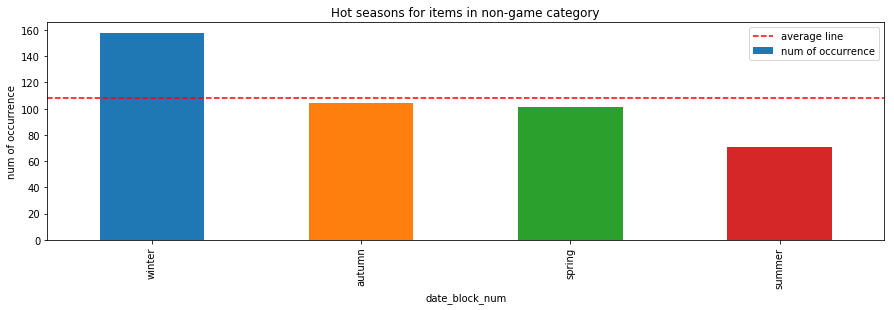

In [59]:
find_important_season(nongame_cat_ids).plot(kind='bar', figsize=(15,4), label='num of occurrence')
plt.title('Hot seasons for items in non-game category')
plt.axhline(find_important_season(nongame_cat_ids).mean(), c='r', ls='--', label='average line')
plt.ylabel('num of occurrence')
plt.xlabel('date_block_num')
plt.legend()
plt.show()

* In overall, revenue tends to rise in `Winter` and `Autumn`.
* For items in `game` category, revenues in `winter` and `autumn` rise above average.
* For items in `non-game` category, revenues in `winter` rise above average.

### `Winter` value in `date_season` column seems to have strong relationshop with revenue in both of categories(`game`, `non-game`).
### Unlikely with items in `non-game` category, revenues from `game` category seems to have increased in `Autumn` as well.

In [184]:
hotmonth_map = {1:1,
               2:1,
               3:0,
               4:0,
               5:0,
               6:0,
               7:0,
               8:0,
               9:0,
               10:1,
               11:1,
               12:1}
train['is_hotmonth'] = train['date_month'].map(hotmonth_map)

## Which `shop` s have the ability to catch the trend?
Since there is no products limited to certain area/location, we can assume that all the `shop`s can list any product to their lineups if they want to.

* We calculate the `on_trend` by `date_block_num` for each product
* Then, we can find out `shop`s catching the trend in time and reflect that in their product lineup.

We can add the values representing the ability to catch trends as `trendy_index` and assign them for each `shop` in the data set.

In [185]:
# function to get the line-ups for each store by each month(date_block_num)

def get_selling_items_by_month(shop_id, month_num):
    
    shop_month_index = (train['shop_id']==shop_id) & (train['date_block_num']==month_num)
    
    return train[shop_month_index]['item_category_id_withstring'].unique().tolist()

In [186]:
print(get_selling_items_by_month(35, 0))

['pc games30', 'cinema40', 'books45', 'books49', 'programs73', 'gifts67', 'programs77', 'music55', 'games23', 'games19', 'pc games28', 'games22', 'games21', 'pc games29', 'accessories4', 'gifts62', 'programs75', 'accessories2', 'accessories5', 'payment cards35', 'games25', 'game consoles14', 'game consoles13', 'accessories6', 'game consoles15', 'payment cards33', 'cinema38', 'cinema37', 'cinema41', 'gifts65', 'books43', 'gifts63', 'gifts70', 'music60', 'accessories3', 'gifts64', 'game consoles11', 'gifts69', 'office79', 'gifts72', 'gifts61']


In [187]:
# calculate the hot period by each unique item category id (withstring)
# and store them as dictionary as 'itemid : [hotmonth1, hotmonth2, ...]'

hot_months_by_item = {}
for itemid in train['item_category_id_withstring'].unique():
    #print(itemid)
    hot_months_by_item[itemid] = calc_hot_period(itemid)[1] 
    #print('...done...')

In [188]:
def calc_trend_power_of_shop(shop_id):
    
    # take the unique id for shop
    # calculate how much the shop catches the trend flows and add the trendy item to their lineup
    
    lineups_by_months = [get_selling_items_by_month(shop_id, month) for month in range(34)]
    trend_power = 0
    
    # iterate monthly lineups for the shop
    for month_num, lineup in enumerate(lineups_by_months):
        
        # for each item in the monthly lineup
        for item in lineup:
            
            # get the hot months for the item
            hotmonths = hot_months_by_item[item]
            
            # if the item is in its period
            if month_num in hotmonths:
                trend_power += 1
            
    return shop_id, trend_power

In [198]:
def calc_trend_power_of_shop_majoritems(shop_id):
    
    # take the unique id for shop
    # calculate how much the shop catches the trend flows and add the trendy item to their lineup
    
    lineups_by_months = [get_selling_items_by_month(shop_id, month) for month in range(34)]
    trend_power = 0
    
    # iterate monthly lineups for the shop
    for month_num, lineup in enumerate(lineups_by_months):
        
        # for each item in the monthly lineup
        for item in lineup:
            
            if ('game' in item) or ('cinema' in item) or ('gifts' in item):
            
                # get the hot months for the item
                hotmonths = hot_months_by_item[item]

                # if the item is in its period
                if month_num in hotmonths:
                    trend_power += 1
            
    return shop_id, trend_power

In [101]:
# test
calc_trend_power_of_shop(21)

(21, 458)

In [199]:
calc_trend_power_of_shop_majoritems(21)

(21, 262)

In [200]:
from concurrent.futures import thread
pool = thread.ThreadPoolExecutor(max_workers=3)
trend_power_by_shops = dict(pool.map(calc_trend_power_of_shop, 
                                sorted(train['shop_id'].unique().tolist())))
major_trend_power_by_shops = dict(pool.map(calc_trend_power_of_shop_majoritems, 
                                sorted(train['shop_id'].unique().tolist())))

## Plot `trend_power` against `total_revenue`
* From the scatter plot, we can generate a new column to represent the `trend_power` numeric values for each shop.

In [201]:
tot_revenues_by_shops = train.groupby('shop_id')['revenue_month'].sum()

In [202]:
from matplotlib import pyplot as plt
%matplotlib inline

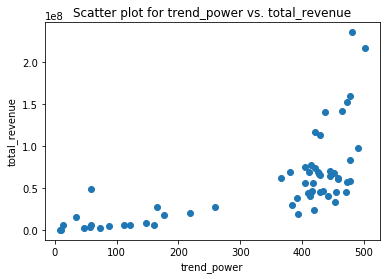

In [203]:
plt.title('Scatter plot for trend_power vs. total_revenue')
plt.scatter(trend_power_by_shops.values(), tot_revenues_by_shops)
plt.xlabel('trend_power')
plt.ylabel('total_revenue')
plt.show()

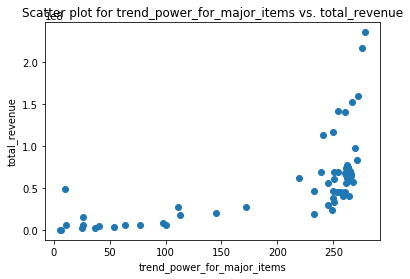

In [206]:
plt.title('Scatter plot for trend_power_for_major_items vs. total_revenue')
plt.scatter(major_trend_power_by_shops.values(), tot_revenues_by_shops)
plt.xlabel('trend_power_for_major_items')
plt.ylabel('total_revenue')
plt.show()

In [211]:
trend_power_by_shops_df = pd.DataFrame({'shop_id':list(trend_power_by_shops.keys()),
                                         'trend_power':list(trend_power_by_shops.values())})

major_trend_power_by_shops_df = pd.DataFrame({'shop_id':list(major_trend_power_by_shops.keys()),
                                         'major_trend_power':list(major_trend_power_by_shops.values())})

In [212]:
train = train.join(trend_power_by_shops_df.set_index('shop_id'))
train = train.join(major_trend_power_by_shops_df.set_index('shop_id'))

In [213]:
train.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price_month,date_month,date_year,item_category_id,shop_loc,shop_loc_dist,...,consumption_growth_perc,retail_sales_perc,unemployment_rate,inflation_rate_cpi_perc,inflation_rate_ppi_perc,item_category_id_withstring,is_game_category,is_hotmonth,trend_power,major_trend_power
0,0,30,1,31,265.0,2,2013,40,yakutsk,Far East,...,4.4,3.9,5.5,6.8,3.7,cinema40,0,1,59.0,26.0
1,0,31,1,11,434.0,2,2013,37,yakutsk,Far East,...,4.4,3.9,5.5,6.8,3.7,cinema37,0,1,47.0,25.0
2,0,32,0,6,221.0,1,2013,40,yakutsk,Far East,...,4.4,3.9,5.5,6.8,3.7,cinema40,0,1,410.0,259.0
3,0,32,1,10,221.0,2,2013,40,yakutsk,Far East,...,4.4,3.9,5.5,6.8,3.7,cinema40,0,1,383.0,245.0
4,0,33,0,3,347.0,1,2013,37,yakutsk,Far East,...,4.4,3.9,5.5,6.8,3.7,cinema37,0,1,441.0,264.0


## Case for item_id `6675` --- relationship among `revenue` & `price` & `num of sold`
* To visualize the inter-relationship, normalize each column and plot.

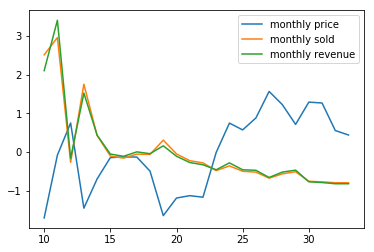

In [260]:
# by month (cumulative)
item_6675_mean_price_by_month = train[train['item_id'] == 6675][['item_price', 'date_block_num']].groupby('date_block_num')['item_price'].mean()
item_6675_total_num_sold_by_month = train[train['item_id'] == 6675][['item_cnt_day', 'date_block_num']].groupby('date_block_num')['item_cnt_day'].sum()
item_6675_total_rev_by_month = train[train['item_id'] == 6675][['revenue', 'date_block_num']].groupby('date_block_num')['revenue'].sum()

date_block_num_unique = item_6675_mean_price_by_month.index

def norm(series):
    return (series - series.mean())/series.std()

plt.plot(date_block_num_unique, norm(item_6675_mean_price_by_month), label='monthly price')
plt.plot(date_block_num_unique, norm(item_6675_total_num_sold_by_month), label='monthly sold')
plt.plot(date_block_num_unique, norm(item_6675_total_rev_by_month), label='monthly revenue')
plt.legend()
plt.show()

## Considering factor `'Seasonality'`

* Some products have seasonal sales patterns - the others got sold in a limited period.
* We can determine which product is seasonal or not
  * And create a column to represent the information.

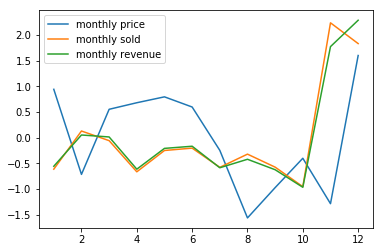

In [262]:
# by month (absolute)
item_6675_mean_price_by_month = train[train['item_id'] == 6675][['item_price', 'date_month']].groupby('date_month')['item_price'].mean()
item_6675_total_num_sold_by_month = train[train['item_id'] == 6675][['item_cnt_day', 'date_month']].groupby('date_month')['item_cnt_day'].sum()
item_6675_total_rev_by_month = train[train['item_id'] == 6675][['revenue', 'date_month']].groupby('date_month')['revenue'].sum()

date_block_num_unique = item_6675_mean_price_by_month.index

def norm(series):
    return (series - series.mean())/series.std()

plt.plot(date_block_num_unique, norm(item_6675_mean_price_by_month), label='monthly price')
plt.plot(date_block_num_unique, norm(item_6675_total_num_sold_by_month), label='monthly sold')
plt.plot(date_block_num_unique, norm(item_6675_total_rev_by_month), label='monthly revenue')
plt.legend()
plt.show()